In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

# Propagating Uncertainties through an Ordinrary Differential Equation

## Objectives

- To propagate uncertainties through an ordinary differential equation.

### Uncertainty propagation through an ordinary differential equation

Ordinary differential equations (ODEs) are commonly used to model the response of physical systems.
Very often, one may be uncertain about the parameters of these ODEs, e.g., physical constants, or even their initial conditions.
The question is how does this uncertainty affect the quantity predicted by the ODE?
How can you mathematically describe this effect, how can you estimate it, and how can you visualize it?
We are going to address these three questions using the a very simple example.

### Exponential decay differential equation and its solution
Consider the prototypical ODE describing the exponential decay of a quantity $y$ over time:

$$
    \dot{y} = \frac{d y}{dt} =-ay(t).
$$

The equation says that the quantity $y$ is decreasing at a rate proportional to itself.
The rate $a$ is the positive variable known as the *exponential decay constant* or *exponential decay rate*.
The exponential decay rate has units of inverse time and it corresponds to the rate with which a unit of $y$ is lost per unit of time. The larger the exponential decay, the faster $y$ dies out over time.
This equation has a plethora of possible interpretations ranging from chemical reactions to electrostatics to heat transfer to radioactivity to thermoelectricity to vibrations.

To solve the equation, we also need *initial conditions*, basically how much $y$ we have at time $t=0$, i.e.,

$$
y(0) = y_0.
$$

The ODE with the initial conditions is called an *initial value problem* (IVP).
For this particular equation, the solution of the initial value problem is analytically available:

$$
y(t) = y_0e^{-at}.
$$

### Assigning random variables to uncertaint quantities

Let's assume that we are uncertain about the decay rate coefficient and the initial conditions.
To model this, we are going to turn both these parameters into random variables.
To do this, we are going to write down everything we know about these parameters and then pick compatible probability distributions.

We start with the decay rate.
We know that it has to be positive.
We have to assign to $a$ a probability distribution with positive support, i.e., a probability distribution that puts zero probability on values that are not positive.
Two of the most commonly used probability distributions are the [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution) and the [Log-Normal](https://en.wikipedia.org/wiki/Log-normal_distribution).
Which one should we pick?
It depends on what we know about it.
Let's say that we expect it to be around $0.1$ (units of inverse time) and that's all we know.
Mathematically, this means that we want the expectation of $a$ to be:

$$
\mathbb{E}[a] = 0.1
$$

If that's all you know then the legitimate thing to do is to assign to $a$ an Exponential distribution with a rate parameter that gives you the right expectation.
Why is this the legitimate thing to do?
Well, that's a big topic which we are going to discuss at a later lecture when we talk about the [principle of maximum entropy](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy).
The short answer is that *the Exponential is the least biased distribution with positive support and a known expectation*.
Mathematically, we write:

$$
a\sim \operatorname{Exp}(\lambda),
$$

and we need to pick $\lambda$ so that $\mathbb{E}[a] = \lambda^{-1} = 0.1$.
So, we have to pick $\lambda = 10$.
Let's visualize this.

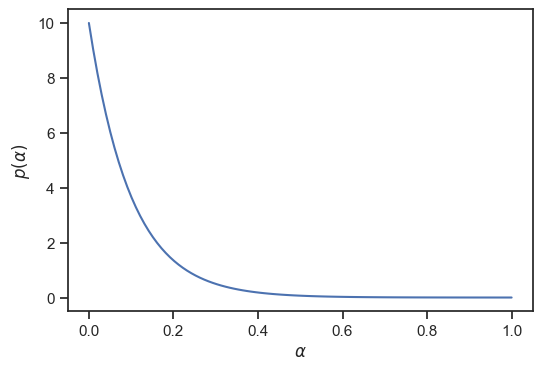

In [2]:
# This is needed to define random variables and sample from them
import scipy.stats as st

# The random variable corresponding to the decay rate a:
# (Please note that the implementation of the exponential in scipy.stats requires the inverse of lambda
# not lambda, read https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html:
#          A common parameterization for expon is in terms of the rate parameter lambda, 
#          such that pdf = lambda * exp(-lambda * x). 
#          This parameterization corresponds to using scale = 1 / lambda.
# ALWAYS READ THE DOCS!!!
# )
a = st.expon(scale=1.0 / 10.)

# Ploting the PDF of a
a_vals = np.linspace(0.0, 1, 100)
fig, ax = plt.subplots()
ax.plot(a_vals, a.pdf(a_vals))
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$p(\alpha)$");

Okay, we have selected a probability model for the rate parameter $a$.
Let's move to the initial conditions $y_0$, which is also positive.
This time, let's assume that we have an expectation for $y_0$, say that we believe that:

$$
\mathbb{E}[y_0] = 10.
$$

If that's all we have, then we would do exactly what we did for the decay rate and proceed by assigning an Exponential distribution to $y_0$ with a properly chosen rate parameter.
But, let's assume we know more. Let's say that we have some idea about the variance of $y_0$.
For example, we may believe that:

$$
\mathbb{V}[y_0] = 1.
$$

Now, the legitimate thing to do is to choose a Log-Normal distribution with the right $\mu$ and $\sigma$ parameters, i.e.,

$$
y_0 \sim \operatorname{Lognormal}(\mu,\sigma^2)
$$

Again, this is based on the [principle of maximum entropy](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy) and it can be interpreted as the *least biased distribution with positive support with a known expectation and variance*.
Now we can match $\mu$ and $\sigma$ to the available information.
For the expectation, we have:

$$
\mathbb{E}[y_0] = \exp\left\{\mu + \frac{1}{2}\sigma\right\} = 10.
$$

For the variance, we have:

$$
\mathbb{V}[y_0] = \left[\exp\{\sigma^2\} - 1\right]\exp\left\{2\mu + \sigma^2\right\} = 1.
$$

We need to solve this system of equations for $\mu$ and $\sigma^2$.
Unfortunately, we do not have the time to work this out analytically.
Let's solve it numerically using [scipy.optimize.root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html#scipy.optimize.root).

First define a function of ``mu`` and ``sigma`` the zero of which corresponds to the solution of the system above:

In [3]:
def f(x):
    mu = x[0]
    sigma = x[1]
    res = np.ndarray((2,))
    # The first equation
    res[0] = np.exp(mu + 0.5 * sigma) - 10.0
    # The second equation
    res[1] = (np.exp(sigma ** 2) - 1.0) * np.exp(2.0 * mu + sigma ** 2) - 1.0
    return res

Now you will also see a standard way to solve a root finding problem:

In [4]:
from scipy.optimize import root

# An initial guess for mu and sigma
x0 = [np.log(10.), 1.0]
sol = root(f, x0)

# Print the result of the optimization
print(sol)

    fjac: array([[-0.034, -0.999],
       [ 0.999, -0.034]])
     fun: array([-1.776e-15, -6.728e-14])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([4.995e-10, 1.282e-11])
       r: array([-388.945, -206.727,   -0.474])
  status: 1
 success: True
       x: array([2.25 , 0.105])


Pay attention to ``sol.fun``. Notice that it is very close to zero. This means that the optimization worked.
The values we found are:

In [5]:
mu = sol.x[0]
sigma = sol.x[1]
print(f"mu = {mu:.2f}")
print(f"sigma = {sigma:.2f}")

mu = 2.25
sigma = 0.10


Let's define the corresponding random variable using [scipy.stats.lognorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) and do a sanity check.
Please notice that scipy.stats is not using the standard parameteterization of the Lognormal.
We have to be a little bit careful with it.
**Always read the documentation of the code you are using and make sure you understand what it does.**
In particular, pay attention to the following text:

> A common parametrization for a lognormal random variable Y is in terms of the mean, ``mu``, and standard deviation, ``sigma``, of the unique normally distributed random variable X such that ``exp(X) = Y``. This parametrization corresponds to setting ``s = sigma`` and ``scale = exp(mu)``.

Now, we know how to match things:

In [6]:
y0 = st.lognorm(s=sigma, scale=np.exp(mu))

Let's visualize the PDF of this random variable:

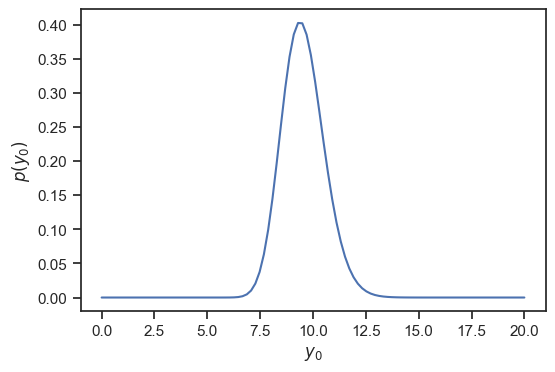

In [7]:
y0_vals = np.linspace(0.0, 20, 100)
fig, ax = plt.subplots()
ax.plot(y0_vals, y0.pdf(y0_vals))
ax.set_xlabel(r"$y_0$")
ax.set_ylabel(r"$p(y_0)$");

## Propagating uncertainties through the initial value problem

As mentioned earlier the solution of the initial value problem at time $t$ is given by the formula:

$$
y(t) = y_0 e^{-at}.
$$

Since $y_0$ and $a$ are random variables, the quantities $y(t)$ at any time $t$ are random variables.
Whenever you have a random variable parameterized by a label like $t$ (time) you say that you have a *random process*.
The first thing we are going to do, is take a few samples of this random process at discrete timesteps.

Specifically, consider some $K$ time steps:

$$
0 = t_1 < t_2 < \dots t_K = 100
$$

and the corresponding values of $y$ at these timesteps:

$$
y_k = y(t_k).
$$

Then, all the $y_k$'s together form a $K$-dimensional random vector which we are going to sample and analyze.
First, here is how you sample it:

In [8]:
# The number of timesteps you want to use
K = 100
# The timesteps
ts = np.linspace(0, 100.0, K)

# The number of samples to take
num_samples = 10000

# Sample some a's
a_samples = a.rvs(num_samples)

# Sample some y0's
y0_samples = y0.rvs(num_samples)

# For each one of these samples, evaluate the solution of the
# initial value problem at all ``K`` timesteps.
# We are going to put the results in a ``num_samples x K`` array:
y_samples = np.ndarray((num_samples, K))
# Loop over all samples
for i in range(num_samples):
    y_samples[i, :] = y0_samples[i] * np.exp(-a_samples[i] * ts)

Now, let's just plot some of the samples as functions of time:

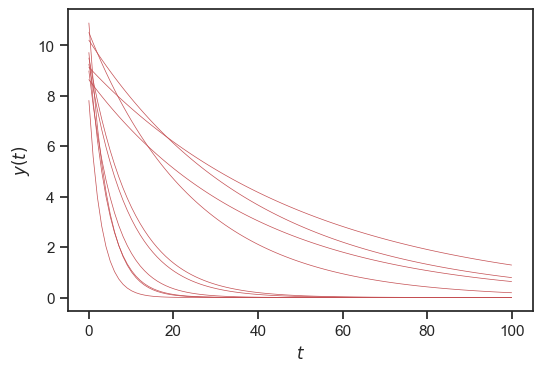

In [9]:
fig, ax = plt.subplots()
ax.plot(ts, y_samples[:10, :].T, color='r', lw=0.5)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y(t)$");

Now, let's focus at an intermediate timestep and let's do our usual analysis (pdf and predictive quantiles).
Let's just pick something close to $t=1$.

In [10]:
# This is now a 1D array, each element being a sample for y(1)
y_close_to_one_samples = y_samples[:, 1]

# Find the quantiles
y_close_to_one_50 = np.quantile(y_close_to_one_samples, 0.5)
y_close_to_one_025 = np.quantile(y_close_to_one_samples, 0.025)
y_close_to_one_975 = np.quantile(y_close_to_one_samples, 0.975)
print(f"median y(1) = {y_close_to_one_50:.2f}")
print(f"y(1) is in [{y_close_to_one_025:.2f}, {y_close_to_one_975:.2f}] with 95% probability")

median y(1) = 8.67
y(1) is in [6.20, 11.02] with 95% probability


Let's plot the empirical CDF of y(1):

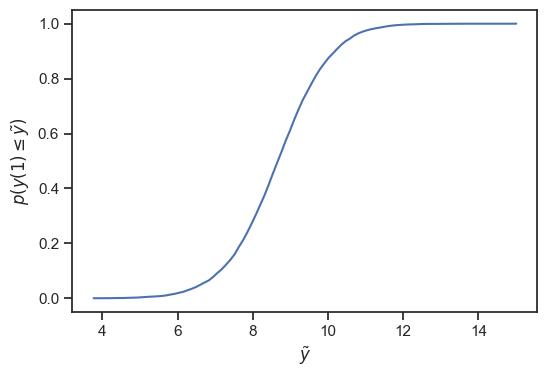

In [11]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf_y_close_to_one = ECDF(y_close_to_one_samples)

fig, ax = plt.subplots()
yys = np.linspace(
    y_close_to_one_samples.min(),
    y_close_to_one_samples.max(),
    100
)
ax.plot(yys, ecdf_y_close_to_one(yys))
ax.set_xlabel(r"$\tilde{y}$")
ax.set_ylabel(r"$p(y(1) \leq \tilde{y})$");

You can use the CDF to find the CDF to find the probability that $y(1)$ falls within a given interval.
For example, here is the probability that $y(1)$ exceeds $8$:

In [12]:
print(f"p(y(1) >= 8) = {1.0 - ecdf_y_close_to_one(8.0):.2f}")

p(y(1) >= 8) = 0.72


Let's now plot the histogram of $y(1)$:

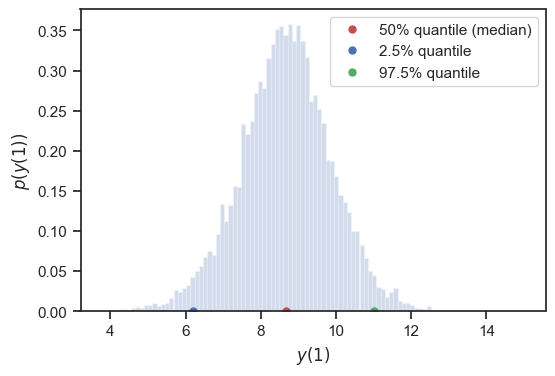

In [13]:
fig, ax = plt.subplots()
ax.hist(
    y_close_to_one_samples,
    density=True,
    alpha=0.25,
    bins=100
)
ax.plot(
    [y_close_to_one_50],
    [0],
    "ro",
    markersize=5,
    label="50% quantile (median)"
)
ax.plot(
    [y_close_to_one_025],
    [0],
    "bo",
    markersize=5,
    label="2.5% quantile"
)
ax.plot(
    [y_close_to_one_975],
    [0],
    "go",
    markersize=5,
    label="97.5% quantile"
)
ax.set_xlabel(r"$y(1)$")
ax.set_ylabel(r"$p(y(1))$")
plt.legend(loc="best");

As we said in the previous handout, the box plot is a nice way to summarize the predictive quantiles:

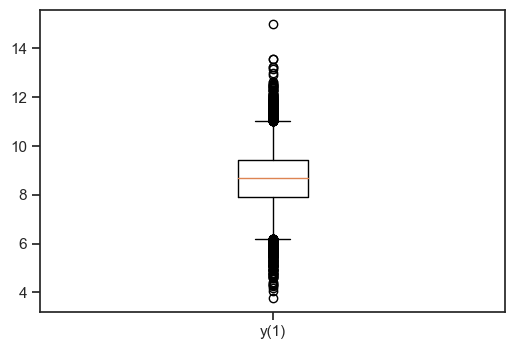

In [14]:
fig, ax = plt.subplots()
ax.boxplot(
    y_close_to_one_samples,
    whis=[2.5, 97.5],
    labels=["y(1)"]
);

This is all good for one timestep. But how can we analyze multiple timesteps.
To begin with, let's subsample our data by taking 10 timesteps between 0 and 2 and by plotting the box plots for each one the corresponding $y(t)$'s.
Here is how to do this:

In [15]:
# This all random observations (first :), but at every 20 timesteps.
y_samples_few_timesteps = y_samples[:, ::20]

# The corresponding timesteps are:
ts_few = ts[::20]

# Let's look at the dimensions of this (number of samples x time of timesteps)
print(y_samples_few_timesteps.shape)

(10000, 5)


Let's do the box plot for all these timesteps:

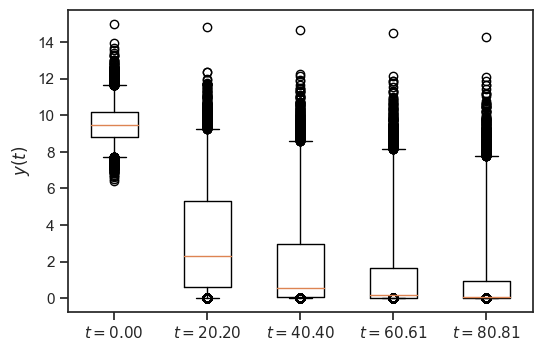

In [16]:
fig, ax = plt.subplots()
ax.boxplot(
    y_samples_few_timesteps,
    whis=[2.5, 97.5], 
    labels=[f"$t={t:1.2f}$" for t in ts_few]
);
ax.set_ylabel(r"$y(t)$");

This is nice because it shows us how the uncertainty evolves over time.
Could we do more steps in between? Yes, but the plot would look very messy if we used boxplots.
We can manually calculate median and the 95\% predictive intervals and plot them as functions of time.
That is, we are now going to estimate the median $\mu_{50}(t_k)$ and the quantiles $\mu_{2.5}(t_k)$ and $\mu_{97.5}(t_k)$ at all timesteps $t_k$.
Here we go:

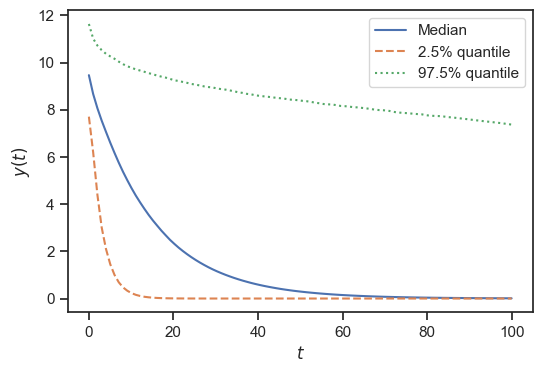

In [17]:
# We can actually do this in one line:
mu_50, mu_025, mu_975 = np.quantile(
    y_samples,
    [0.5, 0.025, 0.975],
    axis=0
)
# Let's plot these:
fig, ax = plt.subplots()
ax.plot(ts, mu_50, label="Median")
ax.plot(ts, mu_025, "--", label="2.5% quantile")
ax.plot(ts, mu_975, ":", label="97.5% quantile")
ax.set_xlabel("$t$")
ax.set_ylabel("$y(t)$")
plt.legend(loc="best");

You could potentially include more quantiles in-between if you like:

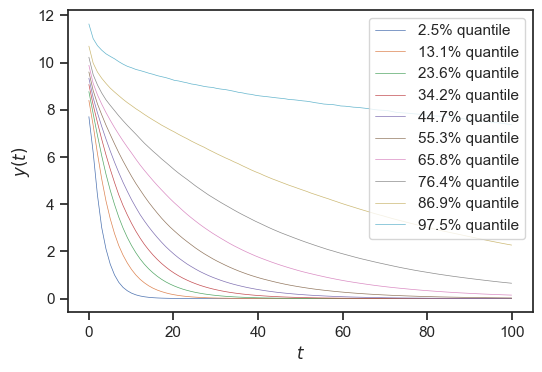

In [18]:
quantiles_to_take = np.linspace(0.025, 0.975, 10)
quants = np.quantile(
    y_samples,
    quantiles_to_take,
    axis=0 
)

fig, ax = plt.subplots()
ax.plot(ts, quants.T, lw=0.5)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y(t)$")
plt.legend(
    [
        f"{q * 100:.1f}% quantile"
        for q in quantiles_to_take
    ],
    loc="best"
);

Another very common way to summarize the uncertainty is to plot the median and then shade the area between the extreme quantiles.
Here is how to do this:

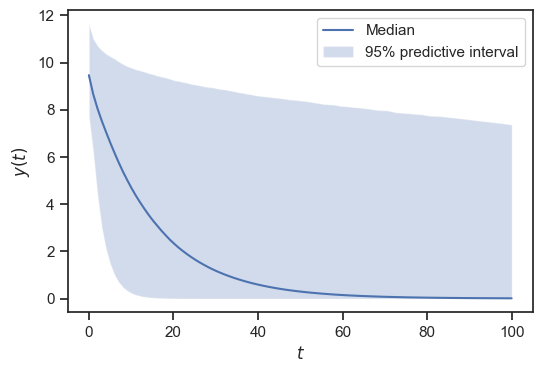

In [19]:
fig, ax = plt.subplots()
ax.plot(ts, mu_50, label="Median")
ax.fill_between(
    ts,
    mu_025,
    mu_975,
    alpha=0.25,
    label="95% predictive interval"
)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y(t)$")
plt.legend(loc="best");

The way you should interpret the predictive interval is that there is a 95% probability that a random trajectory will fall inside (strictly speaking they are *approximately* that).
Let's plot 100 random samples along with the shaded area above:

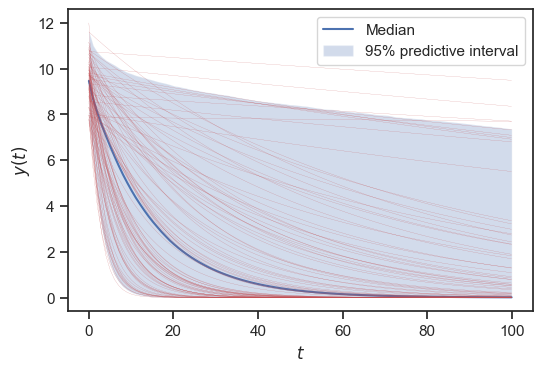

In [20]:
fig, ax = plt.subplots()
ax.plot(ts, mu_50, label="Median")
ax.fill_between(
    ts,
    mu_025,
    mu_975,
    alpha=0.25,
    label="95% predictive interval"
)
ax.set_xlabel("$t$")
ax.set_ylabel("$y(t)$")
plt.legend(loc="best")
ax.plot(
    ts,
    y_samples[:100, :].T,
    "r",
    lw=0.1
);

Finally, two other very common things to plot is the expectation, $\mathbb{E}[y(t)]$, and the variance $\mathbb{V}[y(t)]$ as functions of time.
Let's do them on the same plot:

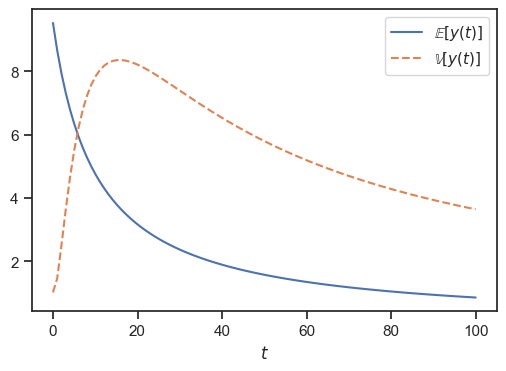

In [21]:
exp_y = np.mean(y_samples, axis=0)
var_y = np.var(y_samples, axis=0)
fig, ax = plt.subplots()
ax.plot(ts, exp_y, label=r"$\mathbb{E}[y(t)]$")
ax.plot(ts, var_y, '--', label=r"$\mathbb{V}[y(t)]$")
ax.set_xlabel(r"$t$")
plt.legend(loc="best");

### Questions

+ Notice that the expectation $\mathbb{E}[y(t)]$ decays with time despite the uncertainty? Why?
+ Notice that the variance $\mathbb{V}[y(t)]$ initially increases, but after a point it starts decreasing.
Will the variance continue to decrease beyond the timestep shown in the figure?
If yes, this is a rare example of a dynamical system that becomes more predictable as time passes.
+ Repeat the analysis above by assuming that you do not know the variance of the initial condition $y_0$.
This can be accomplished by replacing the distribution assigned to $y_0$ with an Exponential distribution.
Do you have less or more uncertainty now?